### Ritajit Majumdar
Enabling Quantum Technologies Researcher @ IBM Quantum

## Scaling quantum computational workflow with LO

In this notebook, we consider the simulation of a period chain of qubits. Due to the periodic nature of this problem, for most practical purposes, it requires a 2-qubit operation between two ends of the hardware topology -- which leads to a significant number of SWAP gates. In this notebook we show the usage of gate cutting to deal with such a problem. Replacing this 2-qubit gate(s) with Local Operations (LO) avoids these SWAP gates required for the long range interaction at the cost of executing multiple instances of the circuit, and some classical postprocessing. In this notebook we shall use the terms <i>Gate cutting<i> and <i>LO<i> interchangeably.

In summary, gate cutting can be incorporated to logically calculate the long distance 2-qubit operations. In other words, this approach leads to an effective increase in the connectivity of the coupling map. Naturally, this leads to a significant lowering of SWAP gates, and thus to improved performance.

For more details on gate cutting, and circuit knitting in general, refer to <a href='https://qiskit-extensions.github.io/circuit-knitting-toolbox/index.html'>circuit-knitting-toolbox</a> and the related tutorials.

In this notebook with show the effect of cutting a single periodic chain of an MBL type circuit and show the improvement it offers without any error mitigation or suppresion techniques.

### 1. Map circuit to quantum hardware native form

For this study we consider a compute-uncompute MBL-like periodic chain. This is the MBL circuit with a periodic 2-qubit operation connecting the last qubit to the first one. MBL is a hardware-native circuit, i.e., it doesn't require SWAP gates for mapping it to the underlying hardware. However, this version of periodic MBL-like chain has a long-range 2-qubit operation between the first and last qubits of the circuit. This one interaction can lead to multiple SWAP gates, increasing the noise in the circuit.

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from numpy import concatenate
from numpy import pi

class MBLChainCircuit(QuantumCircuit):
    """Parameterized MBL non-periodic chain (i.e. 1D) quantum circuit.

    Parameters correspond to interaction strength (θ), and
    disorders vector (φ) with one entry per qubit. In 1D,
    θ < 0.16π ≈ 0.5 corresponds to the MBL regime; beyond such
    critical value the dynamics become ergodic (i.e. thermal).
    Disorders are random on a qubit by qubit basis [1].

    Args:
        num_qubits: number of qubits (must be even).
        depth: two-qubit depth (must be even).
        barriers: if True adds barriers between layers.
        measurements: if True adds measurements at the end.

    Notes:
        [1] Shtanko et.al. Uncovering Local Integrability in Quantum
            Many-Body Dynamics, https://arxiv.org/abs/2307.07552
    """

    def __init__(
        self, num_qubits: int, depth: int, *, barriers: bool = False, measurements: bool = False
    ) -> None:
        num_qubits = _validate_mbl_num_qubits(num_qubits)
        depth = _validate_mbl_depth(depth)
        barriers = bool(barriers)
        measurements = bool(measurements)

        super().__init__(num_qubits, name=f"MBLChainCircuit<{num_qubits}, {depth}>")

        self.x(range(1, num_qubits, 2))  # TODO: add optional initial state arg
        if barriers and depth > 0:
            self.barrier()
        evolution = MBLChainEvolution(num_qubits, depth, barriers=barriers)
        self.compose(evolution, inplace=True)
        if measurements:
            self.measure_all(inplace=True, add_bits=True)


class MBLChainEvolution(QuantumCircuit):
    """Parameterized MBL non-periodic chain (i.e. 1D) evolution quantum circuit.

    Parameters correspond to interaction strength (θ), and
    disorders vector (φ) with one entry per qubit. In 1D,
    θ < 0.16π ≈ 0.5 corresponds to the MBL regime; beyond such
    critical value the dynamics become ergodic (i.e. thermal).
    Disorders are random on a qubit by qubit basis [1].

    Args:
        num_qubits: number of qubits (must be even).
        depth: two-qubit depth.
        barriers: if True adds barriers between layers.

    Notes:
        [1] Shtanko et.al. Uncovering Local Integrability in Quantum
            Many-Body Dynamics, https://arxiv.org/abs/2307.07552
    """

    def __init__(self, num_qubits: int, depth: int, *, barriers: bool = False) -> None:
        num_qubits = _validate_mbl_num_qubits(num_qubits)
        depth = _validate_mbl_depth(depth)
        barriers = bool(barriers)

        super().__init__(num_qubits, name=f"MBLChainEvolution<{num_qubits}, {depth}>")

        theta = Parameter("θ")
        phis = ParameterVector("φ", num_qubits)

        for layer in range(depth):
            layer_parity = layer % 2
            if barriers and layer > 0:
                self.barrier()
            for qubit in range(layer_parity, num_qubits - 1, 2):
                self.cz(qubit, qubit + 1)
                self.u(theta, 0, pi, qubit)
                self.u(theta, 0, pi, qubit + 1)
            if layer_parity == 1:
                self.cz(num_qubits-1,0)
                self.u(theta, 0, pi, num_qubits-1)
                self.u(theta, 0, pi, 0)
            for qubit in range(num_qubits):
                self.p(phis[qubit], qubit)


def _validate_mbl_num_qubits(num_qubits: int) -> int:
    """Validate number of qubits for MBL circuits."""
    if not isinstance(num_qubits, int):
        raise TypeError(f"Invalid num. qubits type {type(num_qubits)}, expected <int>.")
    if num_qubits <= 2:
        raise ValueError(f"Number of qubits ({num_qubits}) must be greater than two.")
    if num_qubits % 2:
        raise ValueError(f"Number of qubits ({num_qubits}) must be even.")
    return num_qubits


def _validate_mbl_depth(depth: int) -> int:
    """Validate depth for MBL circuits."""
    if not isinstance(depth, int):
        raise TypeError(f"Invalid depth type {type(depth)}, expected <int>.")
    if depth < 0:
        raise ValueError(f"Depth ({depth}) must be positive.")
    if depth % 2:
        raise ValueError(f"Depth ({depth}) must be even.")
    return depth

We show the diagram of a 4-qubit circuit for the ease of understanding. Note the long range interaction between qubits $q_3$ and $q_0$. This interaction allows for the periodicity of the problem, but at the same time is not hardware native, and will lead to multiple SWAP gates.

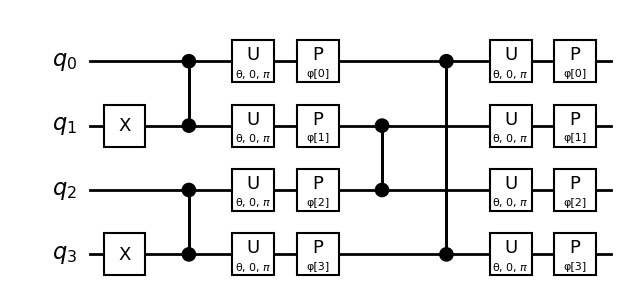

In [2]:
reference_circuit = MBLChainCircuit(num_qubits=4, depth=2, barriers=False, measurements=False)
reference_circuit.draw("mpl", style="bw") 

#### Mirror circuit: the compute-uncompute pattern

A compute-uncompute circuit appends the inverse of the circuit unitary to the circuit, so that ideally the outcome is $|0\rangle^n$, $n$ being the number of qubits. Having a compute-uncompute circuit removes the need of simulating the ideal outcome for verification. However, a depth k MBL-like periodic chain requires k/2 gate cuts. But, when we use the compute-uncompute version, it doubles the number of cuts required.

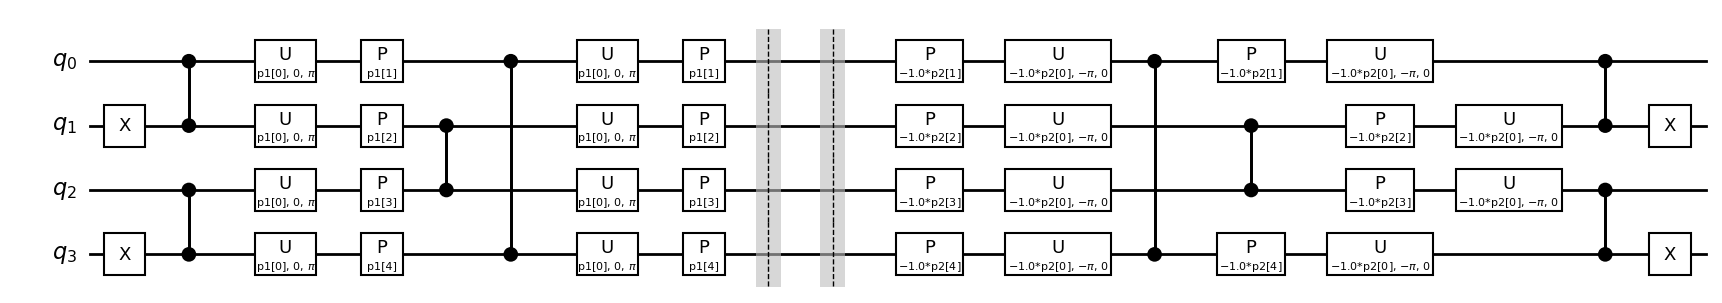

In [3]:
from qiskit.circuit.library import UnitaryOverlap

reference_circuit.barrier()
reference_circuit = UnitaryOverlap(reference_circuit, reference_circuit)

reference_circuit.draw("mpl", style="bw")

Notice that Qiskit requires a barrier between the compute and uncompute parts of the circuit in order to avoid simplification of the circuit to identity during transpilation.

In [4]:
def adds_two_qubit_depth(instruction):
    """Returns True if the instruction adds two-qubit depth, False otherwise."""
    if instruction.operation.name == "barrier":
        return False
    return instruction.operation.num_qubits > 1

depth = reference_circuit.depth(adds_two_qubit_depth)  # Original depth = 2
print(f">> Compute-uncompute 2-qubit depth: {depth} (= 2 x 2)")

>> Compute-uncompute 2-qubit depth: 4 (= 2 x 2)


#### Select backend and initial layout

For this notebook we select a line layout since MBL circuit is native to such a layout.

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2
service = QiskitRuntimeService(channel='ibm_quantum')

In [6]:
backend = service.get_backend('ibm_nazca')

The layout was selected manually to determine a 1D chain while avoiding some significantly noisy qubits and interactions. Note that we can determine the layout by transpilation also by creating a temporary circuit without the long range interaction. This will ensure that the transpilation does not try to minimize SWAP gates arising from the long range interaction, and will find the best 1D chain layout.

In [7]:
init_layout = [
    13,12,11,10,9,8,7,6,5,4,3,2,1,0,14,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,
    36,51,50,49,48,47,46,45,54,64,65,66,67,68,69,70,74,89,88,87,86,85,84,83,82,81,80,
    79,78,77,76,75,90,94,95,96,97,98,99,100,101,102,103,104,111,122,121,120,119,118,
    117,116,115,114
]

The number of qubits in the circuit is governed by the length of the initial layout.

In [8]:
num_qubits = len(init_layout)
num_qubits

84

#### Build the virtual circuit and assign parameters

In [9]:
depth = 2 # depth should be an even number to complete 1 floquet cycle

In [10]:
virtual_circuit = MBLChainCircuit(num_qubits, depth)

Note that the number of long range interactions depend only on the depth of the circuit, and not on the number of qubits. For depth = 2, there is only 1 long range interaction.

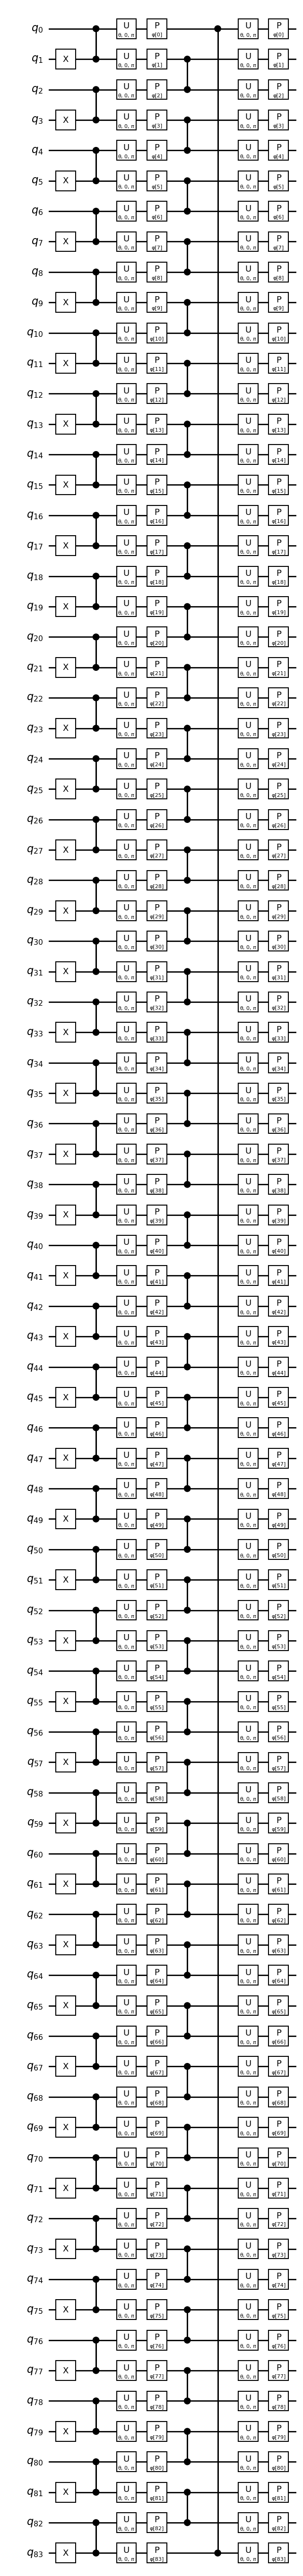

In [11]:
virtual_circuit.draw("mpl", style="bw", fold=-1)

In [12]:
from numpy.random import default_rng
from numpy import pi

rng = default_rng(seed=0)

theta = 0.3  # Note: MBL regime for θ < 0.16π ≈ 0.5
phis = rng.uniform(-pi, pi, size=num_qubits).tolist()

print("PARAMETERS:")
print(f"  θ    := {theta}")
for qubit in range(num_qubits):
    print(f"  φ[{qubit}] := {phis[qubit]}")

PARAMETERS:
  θ    := 0.3
  φ[0] := 0.8605556614246863
  φ[1] := -1.4464727375963786
  φ[2] := -2.8841484100105235
  φ[3] := -3.03774645687452
  φ[4] := 1.9683349641197863
  φ[5] := 2.5934197786078093
  φ[6] := 0.6700123395200417
  φ[7] := 1.441969420022903
  φ[8] := 0.27410390540137985
  φ[9] := 2.7336406607023154
  φ[10] := 1.9845664104768632
  φ[11] := -3.1243861495570098
  φ[12] := 2.2456372993781644
  φ[13] := -2.930568260297326
  φ[14] := 1.4429677267223928
  φ[15] := -2.0379158390962826
  φ[16] := 2.281920468786123
  φ[17] := 0.2605085298868297
  φ[18] := -1.2584473065782806
  φ[19] := -0.4857705158280976
  φ[20] := -2.9636549119444626
  φ[21] := -2.3606977967595952
  φ[22] := 1.072064815449135
  φ[23] := 0.9248189764942678
  φ[24] := 0.7249860371262926
  φ[25] := -0.7308754819569288
  φ[26] := 3.124062163134476
  φ[27] := 3.0211775357715274
  φ[28] := 1.1657946707540434
  φ[29] := 0.9453635139748178
  φ[30] := 1.1840457287093606
  φ[31] := -0.6979272767969258
  φ[32] := -2.2927

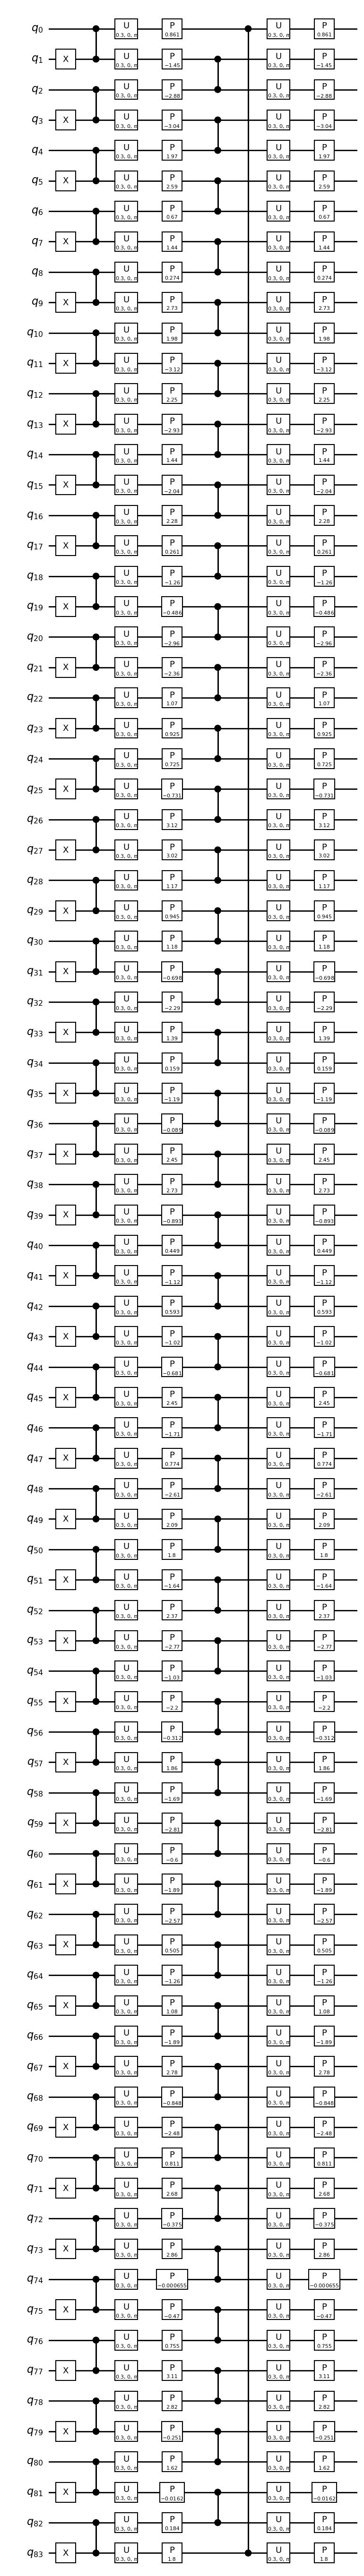

In [13]:
virtual_circuit.assign_parameters([theta, *phis], inplace=True)
virtual_circuit.draw("mpl", style="bw", fold=-1)

Now we append the inverse of the circuit to the circuit to create the compute-uncompute version.

In [14]:
virtual_circuit.barrier()
virtual_circuit = UnitaryOverlap(virtual_circuit, virtual_circuit)

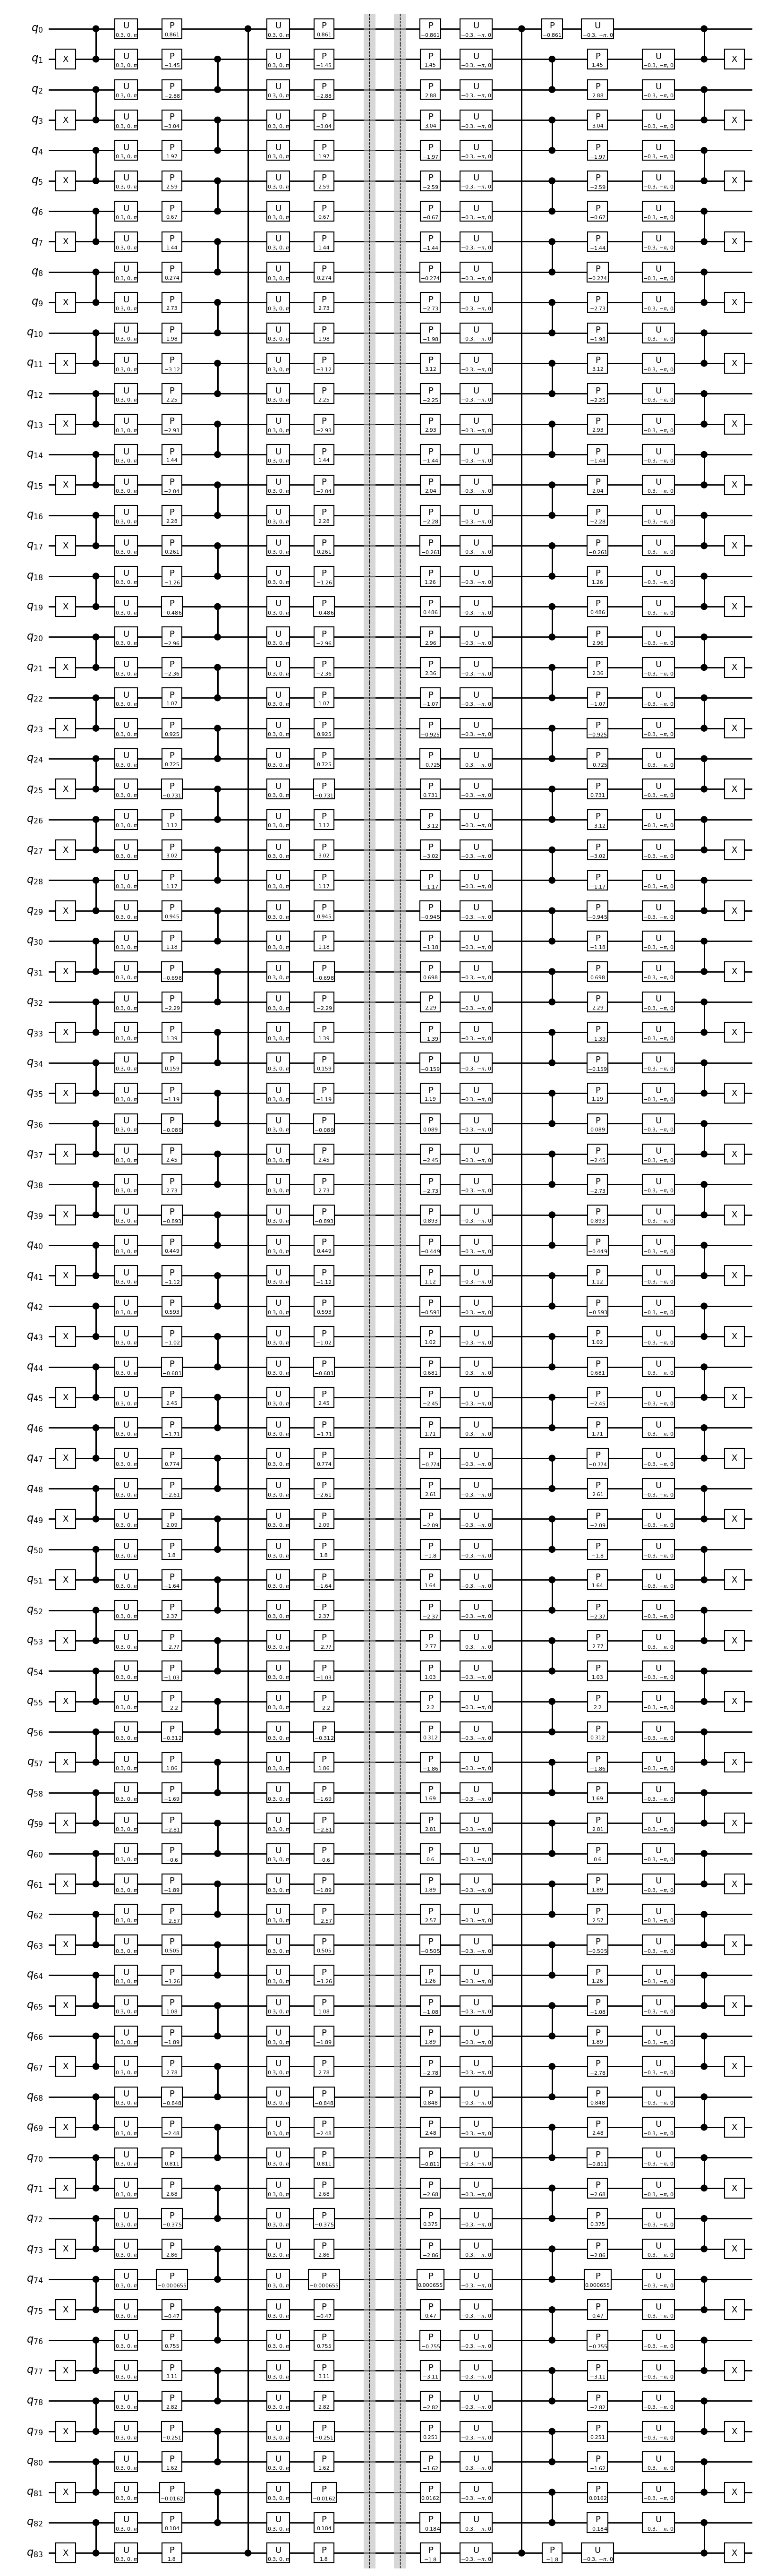

In [15]:
virtual_circuit.draw("mpl", style="bw", fold=-1)

As discussed before, using compute-uncompute method doubles the depth of the circuit. In turn, it also doubles the number of long range interactions. In this compute-uncompute circuit, there are now 2 long range interactions. Therefore, we shall require two gate cuts instead of one for the base circuit.

In [16]:
virtual_circuit.depth(adds_two_qubit_depth)

4

### 2. Optimize circuits and observables

#### Transpile the circuit

Note that transpilation can be performed at this stage, or after cutting. However, if we transpile after cutting, then we need to transpile all the subexperiments generated due to sampling over the subcircuits. Therefore, it is more prudent to transpile at this stage. However, transpilation at this stage will append multiple SWAP gates to place the periodic 2-qubit operation.

However, this problem can be avoided in this case: for this problem, we know the exact gates which will be cut. It is always the periodic 2-qubit gate. So we can create a virtual coupling map by adding virtual connections between far away qubits to accommodate these periodic 2-qubit gates. This will ensure that the circuit can be transpiled at this stage without incorporating the SWAP gates.

In [17]:
coupling_map = backend.configuration().coupling_map

virtual_coupling_map = coupling_map.copy()
virtual_coupling_map.append([init_layout[-1],init_layout[0]])
virtual_coupling_map.append([init_layout[0],init_layout[-1]])

In [18]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm_virtual = generate_preset_pass_manager(3, coupling_map=virtual_coupling_map, initial_layout=init_layout, basis_gates=backend.configuration().basis_gates)

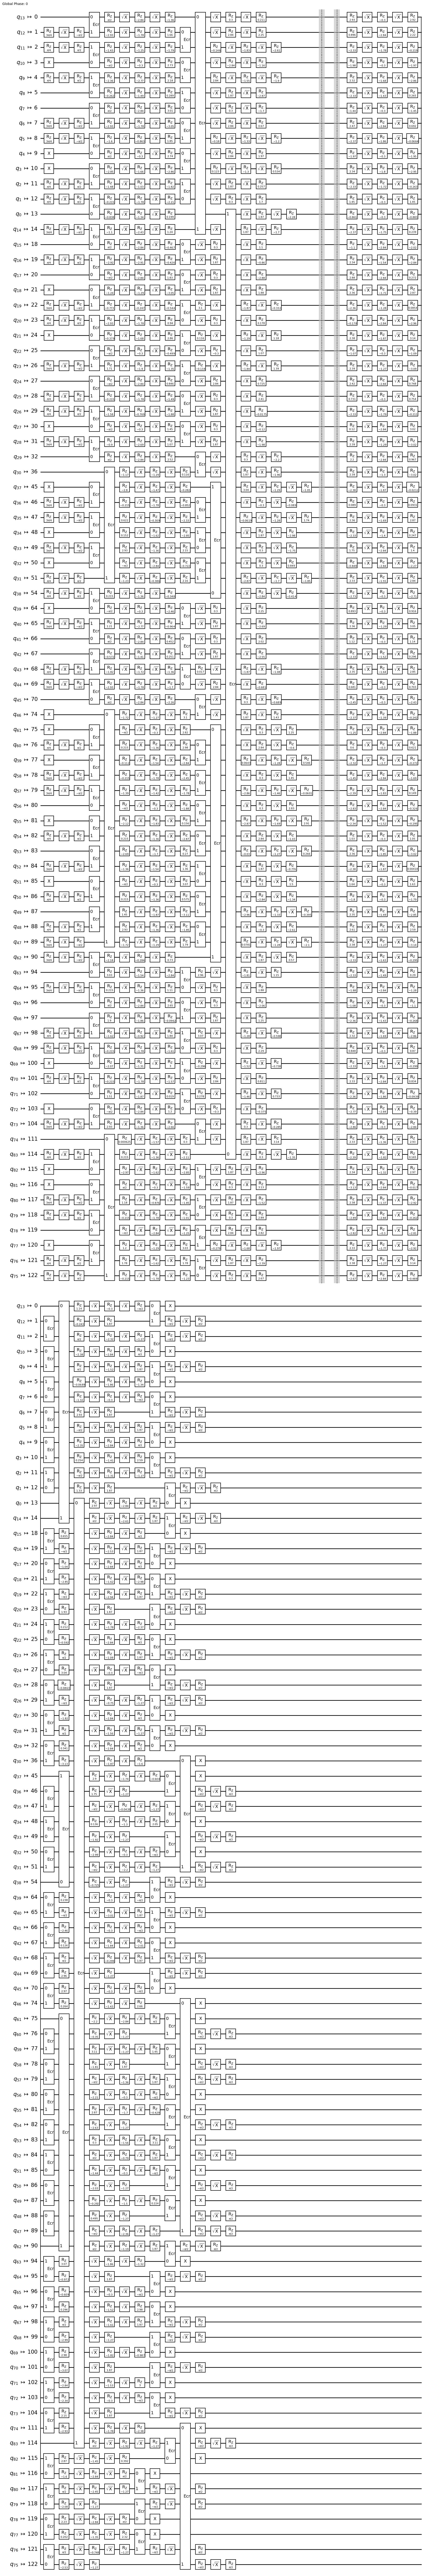

In [19]:
virtual_mapped_circuit = pm_virtual.run(virtual_circuit)
virtual_mapped_circuit.draw('mpl', style='bw', idle_wires=False)

We can verify that the depth of the transpiled circuit remains the same as that of the original circuit.

In [20]:
virtual_mapped_circuit.depth(adds_two_qubit_depth)

4

#### Select observables

We select both weight-1 and nearest neighbour weight-2 observables for this problem. The goal will be to compare the expectation values of the average of weight-1 and weight-2 observables separately.

In [21]:
observables = []

for i in range(num_qubits):
    obs = 'I'*(i)+'Z'+'I'*(num_qubits-i-1)
    observables.append(obs)

for i in range(num_qubits):
    if i == num_qubits-1:
        obs = 'Z'+'I'*(num_qubits-2) + 'Z'
    else:
        obs = 'I'*i+'ZZ'+'I'*(num_qubits-i-2)
    observables.append(obs)

In [22]:
from qiskit.quantum_info import SparsePauliOp

observables = SparsePauliOp(observables)

In [23]:
paulis = observables.paulis
coeffs = observables.coeffs

Now we cut the gates in the transpiled circuit. Note that the 2-qubit gates which need to be cut are the ones connecting the last and the first qubits of the layout.

In [24]:
from circuit_knitting.cutting import cut_gates, generate_cutting_experiments

# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(virtual_mapped_circuit.data)
    if {virtual_mapped_circuit.find_bit(q)[0] for q in instruction.qubits} == {init_layout[-1],init_layout[0]}
]

We modify the observable as per the layout of the transpiled circuit. This takes care of the mapping of the virtual qubits to the physical qubits, and arrange the observable to adhere to that mapping.

In [25]:
trans_observables = observables.apply_layout(init_layout, num_qubits=backend.num_qubits)

Finally the subexperiments are generated by sampling over different measurement and preparation bases.

In [26]:
import numpy as np

qpd_circuit, bases = cut_gates(virtual_mapped_circuit, cut_indices)
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=trans_observables.paulis, num_samples=np.inf
)

### 3. Execute using a Qiskit Primitive

Note that replacing long range interactions with LO leads to the execution of multiple samples of the circuit which differ in the measurement and preparation bases. More information about this can be found in <a href='https://arxiv.org/abs/1909.07534'>Constructing a virtual two-qubit gate by sampling single-qubit operations</a> and <a href='https://arxiv.org/abs/2312.11638'>Cutting circuits with multiple two-qubit unitaries</a>.

In particular, cutting a single 2-qubit gate leads to 6 subcircuit instances. In this example, we have two 2-qubit gates in the compute-uncompute circuit.

In [27]:
print(f'Number of circuit samples to be executed is {len(subexperiments)}')

Number of circuit samples to be executed is 36


At this point, the subexperiments contains circuits with some 1-qubit gates which are not in the basis gate set. This is because the cut qubits are measured in different basis, and the rotation gates used for this does not necessarily belong to the basis gate set. For example, measurement in X basis implies applying a Hadamard gate before the usual measurement in Z basis. But Hadamard is not a part of the basis gate set.

Instead of applying the entire transpilation process on each of the circuits in subexperiments, we can use *BasisTranslator* and then *Optimize1qGatesDecomposition* to ensure that all the gates in these circuits belong to the basis gate set. Using this method is faster than the entire transpilation process, since other steps such as routing, initial layout selection etc. are not performed again.

In [28]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator, Optimize1qGatesDecomposition
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary as sel
from qiskit.transpiler.passes import BasisTranslator
from qiskit.converters import circuit_to_dag, dag_to_circuit

In [29]:
pass_ = PassManager(
    [
        Optimize1qGatesDecomposition(basis=backend.configuration().basis_gates)
    ]
)

In [30]:
subexperiments = pass_.run([dag_to_circuit(
            BasisTranslator(sel, target_basis=backend.basis_gates).run(
                circuit_to_dag(circ)
            )
        )
        for circ in subexperiments])

Now we create a session, and execute the circuit using a Sampler.

In [31]:
session = Session(backend=backend)

We create a sampler and disable dynamical decoupling and twirling. Thus, any improvement we obtain in the result will be solely due to effective application of gate cutting for this type of circuit.

In [32]:
sampler = SamplerV2(session=session)
sampler.options.default_shots = 10000
sampler.options.dynamical_decoupling.enable = False
sampler.options.twirling.enable_gates = False
sampler.options.twirling.enable_measure = False

Now we submit the job to the hardware for execution

In [33]:
cut_job = sampler.run(subexperiments)

In [34]:
cut_job_id = cut_job.job_id()
cut_job_id

'crp8kcxhe9100089hmbg'

In [39]:
result = cut_job.result()

### Step 4: Post process and analyze

We obtain the reconstructed expectation values.

In [40]:
from circuit_knitting.cutting import reconstruct_expectation_values

reconstructed_expvals = reconstruct_expectation_values(
    result,
    coefficients,
    paulis,
)

In [41]:
cut_weight_1 = np.mean(reconstructed_expvals[:num_qubits])
cut_weight_2 = np.mean(reconstructed_expvals[num_qubits:])

In [42]:
print(f'Average of weight-1 expectation values is {cut_weight_1}')
print(f'Average of weight-2 expectation values is {cut_weight_2}')

Average of weight-1 expectation values is 0.8881988095237278
Average of weight-2 expectation values is 0.8132940476189743


### Cross Verify

It is useful to cross-verify the technique against uncut. For that we shall execute the uncut circuit on the backend and calculate the average of weight-1 and weight-2 observables separately. Note that since this is a compute-uncompute circuit, the ideal value for both the observables should be 1. Circuit-knitting-toolbox requires circuits without measurements. For experiment with the uncut circuit, we append the measurement and run it on Sampler. Note that we could have run on estimator as well.

In [35]:
pm_uncut = generate_preset_pass_manager(optimization_level=3, backend=backend, initial_layout=init_layout)

if virtual_circuit.num_clbits == 0:
    virtual_circuit.measure_all()

transpiled_virtual_circuit = pm_uncut.run(virtual_circuit)

Note how significantly the depth of the transpiled circuit increases due to the insertion of SWAP gates when there is no gate cutting.

In [36]:
transpiled_virtual_circuit.depth(adds_two_qubit_depth)

83

In [37]:
uncut_job = sampler.run([transpiled_virtual_circuit])

In [38]:
uncut_job_id = uncut_job.job_id()
uncut_job_id

'crp8kh6q1q4g008menx0'

In [43]:
uncut_result = uncut_job.result()[0]

In [44]:
uncut_counts = uncut_result.data.meas.get_counts()

Now we shall calculate the expectation values of all the observables separately

In [45]:
from qiskit.result import sampled_expectation_value

uncut_expvals = [sampled_expectation_value(uncut_counts, obs) for obs in paulis]

In [46]:
uncut_weight_1 = np.mean(uncut_expvals[:num_qubits])
uncut_weight_2 = np.mean(uncut_expvals[num_qubits:])

In [47]:
print(f'Average of weight-1 expectation values is {uncut_weight_1}')
print(f'Average of weight-2 expectation values is {uncut_weight_2}')

Average of weight-1 expectation values is 0.5226809523809524
Average of weight-2 expectation values is 0.33058095238095236


In [48]:
session.close()

### Visualize

Let us know visualize the improvement obtained for weight-1 and weight-2 observables when using LO for periodic chain MBL circuit

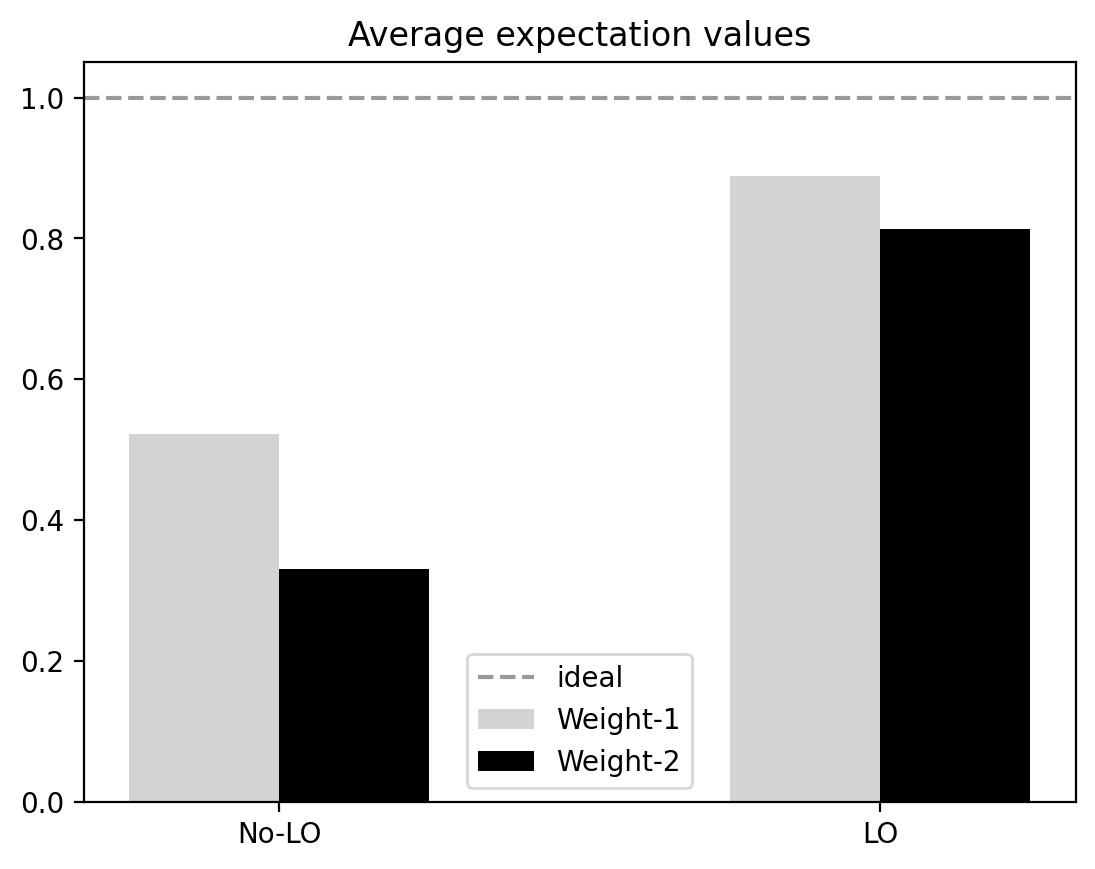

In [49]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

fig, ax = plt.subplots(dpi=200)

width = 0.25
labels = ['No-LO', 'LO']
x = np.arange(len(labels))

wt_1 = [uncut_weight_1, cut_weight_1]
wt_2 = [uncut_weight_2, cut_weight_2]

ax.bar(x - width/2, wt_1, width=width, label='Weight-1', color='lightgrey')
ax.bar(x + width/2, wt_2, width=width, label='Weight-2', color='k')

ax.axhline(y=1.0, color='k', linestyle='--', label="ideal", alpha=0.4)
#ax.set_ylim([0.0, 1.2])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncols=1)
ax.set_title(f"Average expectation values")

plt.show()

#### Inference

We notice that the average of the weight-1 and weight-2 Z type observables are significantly improved due to cutting the periodic gates. The results show $\sim 70\%$ and $\sim 145\%$ improvement in the values of the weight-1 and weight-2 observables respectively. Note that this study does not include any error suppression or mitigation techniques. The improvement observed is solely due to the proper usage of LO for this problem. This study shows that LO can be used effectively in order to improve the performance at utility scale.

In [51]:
import qiskit_ibm_runtime
import qiskit
from importlib.metadata import version

print(f"qiskit runtime version {qiskit_ibm_runtime.version.get_version_info()}")
print(f"qiskit version {qiskit.version.get_version_info()}")
print(f"circuit-knitting-toolbox version {version('circuit-knitting-toolbox')}")

qiskit runtime version 0.23.0
qiskit version 1.0.2
circuit-knitting-toolbox version 0.7.1
